## Tutorial of Causal Tracing

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (figure 1e on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [4]:
import torch
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    IntervenableRepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Oranges"
} 

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(
    name="gpt2-xl",
    cache_dir="../../../.huggingface_cache/",  # change to your local dir
)
gpt.to(device)

base = "The Space Needle is in downtown"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The Space Needle is in downtown
_Seattle             0.9763794541358948
_Bellev              0.0027682818472385406
_Portland            0.0021577849984169006
,                    0.0015149445971474051
_Vancouver           0.0014351375866681337
_San                 0.0013575783232226968
_Minneapolis         0.000938268203753978
.                    0.0007443446083925664
_Tacoma              0.0006097281584516168
_Washington          0.0005885555874556303


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [11]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        # sample gaussian noise
        mean = torch.zeros_like(base[..., : self.interchange_dim])
        stdev = torch.ones_like(base[..., : self.interchange_dim]) * self.noise_level
        noise = torch.normal(mean, stdev)

        # interchange
        base[..., : self.interchange_dim] += noise

        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervenable_interventions_type=NoiseIntervention,
    )
    return intervenable_config

Let's check that this reduced the probability of the output "_Seattle".

In [12]:
base = tokenizer("The Space Needle is in downtown", return_tensors="pt").to(device)
intervenable_config = corrupted_config(type(gpt))
intervenable = IntervenableModel(intervenable_config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_Los                 0.041245896369218826
_Chicago             0.0357482023537159
_San                 0.028079189360141754
_Seattle             0.020032508298754692
.                    0.018648844212293625
_St                  0.0164807066321373
_Detroit             0.014975403435528278
_Phoenix             0.013891089707612991
_Manhattan           0.01368976105004549
_L                   0.012697077356278896


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [118]:
def restore_corrupted_config(model_type, layer, stream="block_output"):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
            IntervenableRepresentationConfig(
                layer,   # layer
                stream,  # intervention type
            ),
        ],
        intervenable_interventions_type=[NoiseIntervention, VanillaIntervention],
    )
    return intervenable_config

def restore_corrupted_with_interval_config(model_type, layer, stream="mlp_activation"):
    start = layer - 4
    end = layer + 6
    if start < 0:
        end += abs(start)
        start = 0
    elif end > 48:
        start -= abs(end-48)
        end = 48
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            IntervenableRepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervenable_interventions_type=[NoiseIntervention]+[VanillaIntervention]*10,
    )
    return intervenable_config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [119]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Seattle")[0]
print(token)

7312


In [120]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(7):
            if stream == "block_output":
                interval = 1
                intervenable_config = restore_corrupted_config(type(gpt), layer_i, stream)
            else:
                interval = 10
                intervenable_config = restore_corrupted_with_interval_config(
                    type(gpt), layer_i, stream)
            intervenable = IntervenableModel(intervenable_config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [base] + [base]*interval,
                {
                    "sources->base": (
                        [[[0, 1, 2, 3]]] + [[[pos_i, pos_i, pos_i, pos_i]]]*interval,
                        [[[0, 1, 2, 3]]] + [[[pos_i, pos_i, pos_i, pos_i]]]*interval,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )
            prob = distrib[0][-1][token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [01:56<00:00,  2.42s/it]


The plot below should now replicate Meng et al.

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf


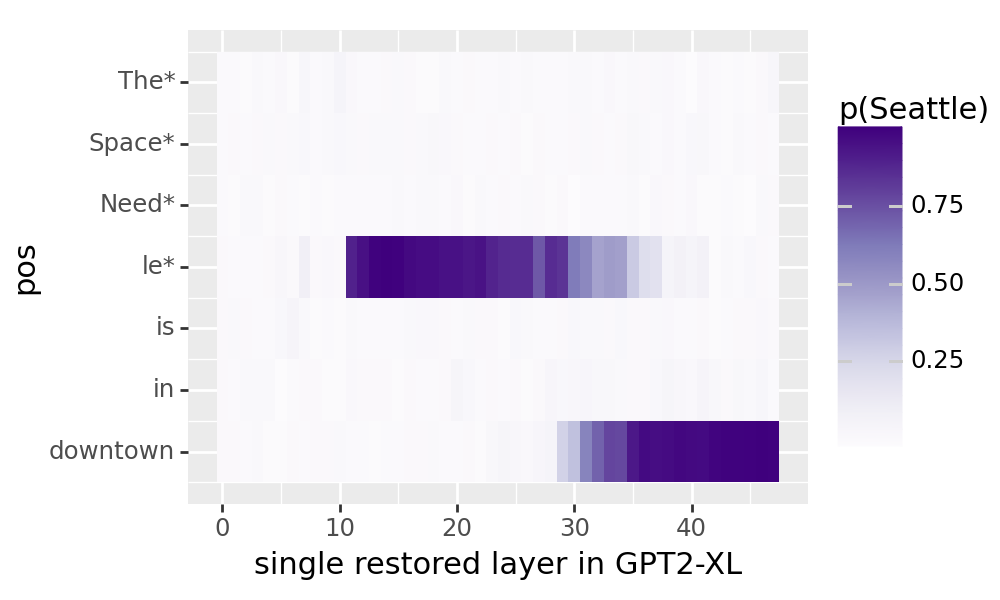

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf


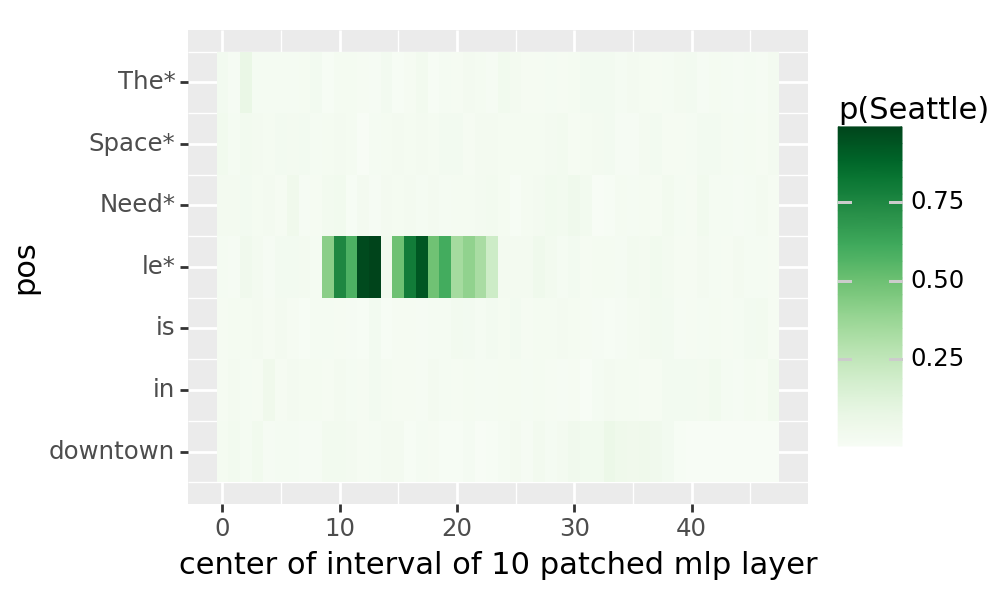

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf


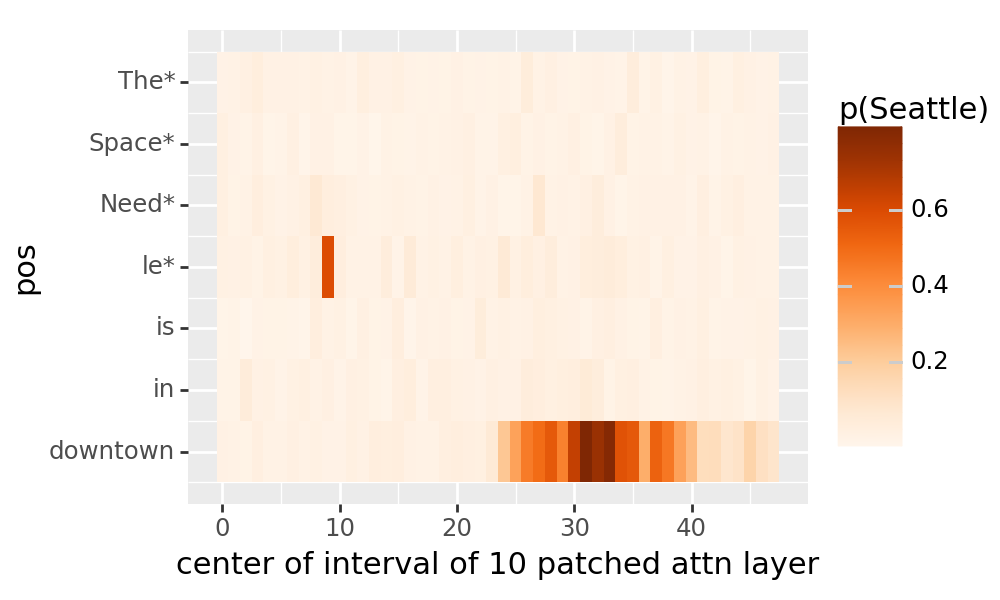

In [5]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Seattle)"] = df["prob"].astype(float)

    custom_labels = ["The*", "Space*", "Need*", "le*", "is", "in", "downtown"]
    breaks = [0, 1, 2, 3, 4, 5, 6]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))    

        + geom_tile(aes(fill="p(Seattle)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5), 
            breaks=breaks, labels=custom_labels) 
        + theme(figure_size=(5, 3))
    )
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    print(plot)